In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [202]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.path import Path
import matplotlib.image as mpimg

# Load the image
image_path = 'IITM_map_without_background.png'  # Replace with your map image path
# image = cv2.imread(image_path)
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image_rgb = mpimg.imread('IITM_map_without_background.png')
img = mpimg.imread('IITM_map_without_background.png')
img_height, img_width = img.shape[:2]  # Get image dimensions


# Load CSV files for each region (forest, instilake, pond1, pond2)
region_files = {
    'forest': 'forest.csv',
    'instilake': 'instilake.csv',
    'pond1': 'pond1.csv',
    'pond2': 'pond2.csv'
}

def load_region_data(region_name):
    """Load the boundary points for a given region from the respective CSV file."""
    if region_name not in region_files:
        raise ValueError(f"Region '{region_name}' not found.")
    df = pd.read_csv(region_files[region_name])
    return df[['X', 'Y']].values

def check_point_in_region_plot(x, y, region_name):
    """Check if the point (x, y) is inside the specified region."""
    # Load the region boundary points
    region_points = load_region_data(region_name)
    
    # Create a Path object from the boundary points
    polygon_path = Path(region_points)
    
    # plt.imshow(image_rgb)
    plt.figure(figsize=(img_width/100, img_height/100))  # Adjust figure size to match image size in inches

    # Plot the image at its original size
    plt.imshow(img, extent=[0, img_width, 0, img_height])
    # # Plot the map, region boundary, and point
    # plt.imshow(img)
    
    # Plot the boundary points with reduced size
    plt.scatter(region_points[:, 0], region_points[:, 1], s=10, c='blue', label=f'{region_name} boundary points')  # s=10 for smaller points
    
    # Connect the adjacent boundary points with a line
    plt.plot(region_points[:, 0], region_points[:, 1], 'b-', lw=1)  # lw=1 for thinner lines
    
    # Close the loop by connecting the last point to the first
    plt.plot([region_points[-1, 0], region_points[0, 0]], [region_points[-1, 1], region_points[0, 1]], 'b-', lw=1)
    
    # Plot the point you want to check
    plt.scatter(x, y, c='red', label='Query Point', s=50)  # Larger point for the query location
    
    
    plt.title(f"Point in {region_name} region")
    plt.legend()
    plt.show()
    
    # Check if the point is inside the polygon
    return polygon_path.contains_point((x, y))

def check_point_in_region(x, y, region_name):
    """Check if the point (x, y) is inside the specified region."""
    # Load the region boundary points
    region_points = load_region_data(region_name)
    
    # Create a Path object from the boundary points
    polygon_path = Path(region_points)
    
    # Check if the point is inside the polygon
    return polygon_path.contains_point((x, y))


def check_point_in_region_plot_all(region_names):
    """Plot the boundaries for the specified regions with different colors."""
    
    # Define a list of colors to use for each region
    colors = ['blue', 'green', 'red', 'orange']  # You can modify or extend this list

    # Initialize a new plot
    plt.figure(figsize=(img_width / 100, img_height / 100))  # Adjust figure size to match image size in inches

    # Plot the image at its original size
    plt.imshow(img, extent=[0, img_width, 0, img_height])

    # Iterate through each region and plot its boundary with a different color
    for i, region_name in enumerate(region_names):
        # Load the region boundary points
        region_points = load_region_data(region_name)

        # Create a Path object from the boundary points
        polygon_path = Path(region_points)

        # Assign a color from the list (wrap around if more regions than colors)
        color = colors[i % len(colors)]

        # Plot the boundary points with reduced size
        plt.scatter(region_points[:, 0], region_points[:, 1], s=10, c=color, label=f'{region_name} boundary points')

        # Connect the adjacent boundary points with a line in the same color
        plt.plot(region_points[:, 0], region_points[:, 1], '-', lw=1, color=color)

        # Close the loop by connecting the last point to the first
        plt.plot([region_points[-1, 0], region_points[0, 0]], 
                 [region_points[-1, 1], region_points[0, 1]], '-', lw=1, color=color)
    
    # Set the plot title and legend
    plt.title(f"Region boundaries")
    plt.legend()
    
    # Show the plot
    plt.show()

    

In [248]:
scale = 2.7

In [246]:
def properties(x,y):
    if check_point_in_region(x, y, 'instilake') == True or check_point_in_region(x, y, 'pond1') == True or check_point_in_region(x, y, 'pond2') == True:
        return 0.6*5*1e8, 1000*(2.7**3), 4184
    
    if check_point_in_region(x, y, 'forest') == True:
        return 0.128*5*1e8, 450*(2.7**3), 1530 
    
    else:
        return 0.1152*5*1e8, 405*(2.7**3), 1377

In [247]:
def forcing(x,y):
    P = 500*1e6*(2.7)**2
    x0 = 472
    y0 = 486.7
    sigma = (5*8/2.7)
    f = (P/(2*np.pi*(sigma**2))**0.5)*np.exp(-1*((x-x0)**2 + (y-y0)**2)/(2*sigma**2))
    return f

In [138]:
def triangle_jacobian(x1,y1,x2,y2,x3,y3):
    dx_deps = -x1 + x2
    dx_deta = -x1 + x3
    dy_deps = -y1 + y2
    dy_deta = -y1 + y3
    
    jacobian = dx_deps*dy_deta - dx_deta*dy_deps
    return jacobian

In [10]:
def jac_matrix(x1,y1,x2,y2,x3,y3):
    dx_deps = -x1 + x2
    dx_deta = -x1 + x3
    dy_deps = -y1 + y2
    dy_deta = -y1 + y3
    jac = np.array([[dx_deps, dy_deps],[dx_deta, dy_deta]])
    return jac

In [11]:
def heron(x1,y1,x2,y2,x3,y3):
    area = 0.5*(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    if area >= 0:
        return area
    else:
        return -1*area

In [12]:
def construct_bilinear(total_nodes, node_tags, triangle):
    
    n = total_nodes
    A_x = np.zeros((n,n))
    A_y = np.zeros((n,n))
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        x1,y1,x2,y2,x3,y3 = triangle[i]
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        
        a_x = np.zeros((3,3))
        a_y = np.zeros((3,3))
        jacobian = jac_matrix(x1,y1,x2,y2,x3,y3)
        dphi = np.linalg.inv(jacobian) @ np.array([[-1,1,0],[-1,0,1]])
        for j in range(len(weights)):
            # N_x = np.array([-1, 1, 0]) * (1/(x2-x1)) + np.array([-1, 0, 1])*(1/(x3-x1))
            # N_y = np.array([-1, 1, 0]) * (1/(y2-y1)) + np.array([-1, 0, 1])*(1/(y3-y1))
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            kappa = properties(x,y)[0]
            N_x = dphi[0,:]
            N_y = dphi[1,:]
            N_x = N_x.reshape((3, 1))
            N_y = N_y.reshape((3, 1))
            a_x += (N_x @ N_x.T)*jac*weights[j]*kappa
            a_y += (N_y @ N_y.T)*jac*weights[j]*kappa
        
        for k in range(3):
            for l in range(3):
                A_x[int(nodes[k]-1), int(nodes[l]-1)] += a_x[k][l]
                A_y[int(nodes[k]-1), int(nodes[l]-1)] += a_y[k][l]
                    
        # A_2d[0,0] += (numerical_intergation(neg_func, xi, xi_1)*jac)
        # A_2d[0,1] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,0] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,1] += (numerical_intergation(pos_func, xi, xi_1)*jac)
        
        # A[i:i+2, i:i+2] += A_2d
        
    return A_x, A_y

In [13]:
def construct_forcing(total_nodes, node_tags, triangle):
    
    n = total_nodes
    f = np.zeros((n,1))
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        x1,y1,x2,y2,x3,y3 = triangle[i]
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        
        f_2d = np.zeros((3,1))
        for j in range(len(weights)):
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            N = forcing(x,y)*np.array([1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1]])
            N = N.reshape((3, 1))
            f_2d += (N)*jac*weights[j]
        
        for k in range(3):
                f[int(nodes[k]-1)] += f_2d[k]
                    
        # A_2d[0,0] += (numerical_intergation(neg_func, xi, xi_1)*jac)
        # A_2d[0,1] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,0] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,1] += (numerical_intergation(pos_func, xi, xi_1)*jac)
        
        # A[i:i+2, i:i+2] += A_2d
        
    return f

In [14]:
def static_solution(BC, total_nodes, boundary_nodes, A_x, A_y, f):
    if BC == "neuman":
        K = A_x + A_y
        C = np.linalg.inv(K) @ f
        return C
        
    if BC == "dirichlet":
        t_amb = 309
        K = A_x + A_y
        boundary = boundary_nodes - 1
        n = total_nodes
        C = np.zeros((n,1))
        C[boundary] = t_amb
        unknown_indices = np.setdiff1d(np.arange(n), boundary)

        # Extract submatrix K_uu (rows and columns corresponding to unknowns)
        K_uu = K[np.ix_(unknown_indices, unknown_indices)]
        K_uu_2 = K[np.ix_(unknown_indices, boundary)]
        
        rhs = f[unknown_indices] - (K_uu_2 @ C[boundary])
        C_uu = np.linalg.inv(K_uu) @ rhs

        # Place the solved values back into the original C array at the correct indices
        C[unknown_indices] = C_uu
        
        return C
    
    else:
        print("Enter a valid Boundary Condition")
        return
        

In [15]:
def construct_mass(total_nodes, node_tags, triangle, del_t):
    
    n = total_nodes
    M = np.zeros((n,n))
    
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        x1,y1,x2,y2,x3,y3 = triangle[i]
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        
        a_m = np.zeros((3,3))
        # a_pho_cp_delt = np.zeros((3,3))
        for j in range(len(weights)):
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            pho,cp = properties(x,y)[1], properties(x,y)[2]
            N = np.array([1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1]])
            N = N.reshape((3, 1))
            a_m += (N @ N.T)*jac*weights[j]*(pho*cp/del_t)
            # a_pho_cp_delt += (N @ N.T)*jac*weights[j]*(pho*cp/del_t)
            
        for k in range(3):
            for l in range(3):
                M[int(nodes[k]-1), int(nodes[l]-1)] += a_m[k][l]
                    
        # A_2d[0,0] += (numerical_intergation(neg_func, xi, xi_1)*jac)
        # A_2d[0,1] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,0] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,1] += (numerical_intergation(pos_func, xi, xi_1)*jac)
        
        # A[i:i+2, i:i+2] += A_2d
        
    return M

In [284]:
def transient_solution(BC, total_nodes, boundary_nodes, A_x, A_y, f, M, C_old):
    if BC[0] == "neuman" and BC[1] == "explicit":
        K = A_x + A_y
        C_new = np.linalg.inv(M) @ ((M - K)@ C_old + f)
        return C_new
    
    if BC[0] == "neuman" and BC[1] == "implicit":
        K = A_x + A_y
        C_new = np.linalg.inv(M + K) @ (M @ C_old + f)
        return C_new
    
    
    
    if BC[0] == "dirichlet" and BC[1] == "explicit":
        t_amb = 309
        K = A_x + A_y
        boundary = boundary_nodes - 1
        n = total_nodes
        C_new = np.zeros((n,1))
        C_new[boundary] = t_amb
        unknown_indices = np.setdiff1d(np.arange(n), boundary)

        # Extract submatrix K_uu (rows and columns corresponding to unknowns)
        K_uu = K[np.ix_(unknown_indices, unknown_indices)]
        M_uu = M[np.ix_(unknown_indices, unknown_indices)]
        M_uu_2 = M[np.ix_(unknown_indices, boundary)]
        rhs = f[unknown_indices] + ((M - K) @ C_old)[unknown_indices]
        # C_old_uu = C_old[unknown_indices]
        C_uu = np.linalg.inv(M_uu) @ (rhs - (M_uu_2 @ C_new[boundary]))

        # Place the solved values back into the original C array at the correct indices
        C_new[unknown_indices] = C_uu
        
        return C_new
    
    if BC[0] == "dirichlet" and BC[1] == "implicit":
        t_amb = 309
        K = A_x + A_y
        boundary = boundary_nodes - 1
        n = total_nodes
        C_new = np.zeros((n,1))
        C_new[boundary] = t_amb
        unknown_indices = np.setdiff1d(np.arange(n), boundary)

        # Extract submatrix K_uu (rows and columns corresponding to unknowns)
        K_uu = K[np.ix_(unknown_indices, unknown_indices)]
        M_uu = M[np.ix_(unknown_indices, unknown_indices)]
        M_uu_2 = M[np.ix_(unknown_indices, boundary)]
        K_uu_2 = K[np.ix_(unknown_indices, boundary)]
        rhs = f[unknown_indices] + (M @ C_old)[unknown_indices]
        # C_old_uu = C_old[unknown_indices]
        C_uu = np.linalg.inv(M_uu + K_uu) @ (rhs - (M_uu_2 + K_uu_2)@C_new[boundary])

        # Place the solved values back into the original C array at the correct indices
        C_new[unknown_indices] = C_uu
        
        return C_new

In [139]:
num = [35, 30, 25, 20, 17.5, 15]
point = np.array([700, 500])
solution_array = []
total_triangles_array = []
point_indices_total = []
point_coordinates_final = []
temp_array = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    # gmsh.open(f'IITM_Map_lc_{num[i]}.msh')
    gmsh.open(f'IITM_Map_sf{num[i]}')
    
    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))

    triangle = []
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        # area1 = heron(point[0], point[1], x2,y2,x3,y3)
        # area2 = heron(point[0], point[1], x1,y1,x3,y3)
        # area3 = heron(point[0], point[1], x2,y2,x1,y1)
        # area = heron(x1, y1, x2,y2,x3,y3)
        # if area == area1 + area2 + area3:
        #     point_indices.append(nodes[0]-1)
        #     point_indices.append(nodes[0]-1)
        #     point_indices.append(nodes[0]-1)
        #     point_coordinates = [x1, y1, x2, y2, x3, y3]
            
        #     point_indices_total.append(point_indices)
        #     point_coordinates_final.append(point_coordinates)
            
        triangle.append([x1,y1,x2,y2,x3,y3])
        
    triangle = np.array(triangle)



    # Retrieve boundary entities (1D entities in 2D mesh)
    boundary_dim = 1  # For 2D meshes, boundary lines are 1D entities
    boundary_tags = gmsh.model.getEntities(boundary_dim)

    # Initialize arrays to store line coordinates and node numbers
    boundary_lines = []
    boundary_nodes = []
    boundary_nodes_set = set()
    # Loop through boundary entities
    for dim, tag in boundary_tags:
        element_types, element_tags, node_tags_boundary = gmsh.model.mesh.getElements(dim, tag)
        node_tags_boundary = node_tags_boundary[0].reshape((-1, 2))  # Each 1D element is a line with 2 nodes

        # Loop through each line element (defined by 2 nodes)
        for nodes in node_tags_boundary:
            n1, n2 = nodes  # Convert to 0-based indexing
            x1, y1 = coordinates[int(n1), :2]  # Get coordinates for node 1
            x2, y2 = coordinates[int(n2), :2]  # Get coordinates for node 2
            boundary_lines.append([x1, y1, x2, y2])
            boundary_nodes.append([n1 + 1, n2 + 1])  # Store original 1-based node numbers
            boundary_nodes_set.add(n1)
            boundary_nodes_set.add(n2)

    # Convert lists to numpy arrays
    boundary_lines = np.array(boundary_lines)  # Shape: (no. of lines, 4) -> [x1, y1, x2, y2]
    boundary_nodes = np.array(boundary_nodes, dtype=int)  # Shape: (no. of lines, 2) -> [node1, node2]
    boundary_nodes_set = np.array(list(boundary_nodes_set), dtype=int)   
    
    A_x, A_y = construct_bilinear(total_nodes, node_tags, triangle)
    f = construct_forcing(total_nodes, node_tags, triangle)
    C_static = static_solution("dirichlet", total_nodes, boundary_nodes_set, A_x, A_y, f)
    solution_array.append(C_static)
    total_triangles_array.append(node_tags.shape[0])
    xy_coordinates = sorted_coordinates[:, :2]
    point_index = np.argmin(np.sum((xy_coordinates - point)**2, axis=1))
    point_indices_total.append(point_index)
    point_coordinates_final.append(sorted_coordinates[point_index])
    # print(point_coordinates)
    # x1, y1, x2, y2, x3, y3 = point_coordinates
    # coeff = np.array([[x2-x1, x3 - x1], [y2-y1, y3-y1]])
    # parametric = np.linalg.inv(coeff) @ np.array([[point[0] - x1], [point[1] - y1]])
    # temp_val = C_static[point_indices[0]] * (1 - parametric[0] - parametric[1]) + C_static[point_indices[1]] * (parametric[0]) + C_static[point_indices[2]] * (parametric[1])
    temp_val = C_static[point_index]
    temp_array.append(temp_val)
    

In [140]:
point_coordinates_final

[array([709.19540449, 501.87136383,   0.        ]),
 array([709.19540449, 501.87136383,   0.        ]),
 array([699.24909212, 495.55602078,   0.        ]),
 array([699.35661855, 507.22141102,   0.        ]),
 array([700.20320426, 496.70208913,   0.        ]),
 array([701.48359507, 498.84697595,   0.        ])]

In [141]:
temp_array

[array([370.21717716]),
 array([370.21717712]),
 array([380.34061679]),
 array([380.00642638]),
 array([379.19506215]),
 array([378.85772644])]

In [222]:
total_triangles_array

[1758, 3516, 4900, 6160, 8602, 10582]

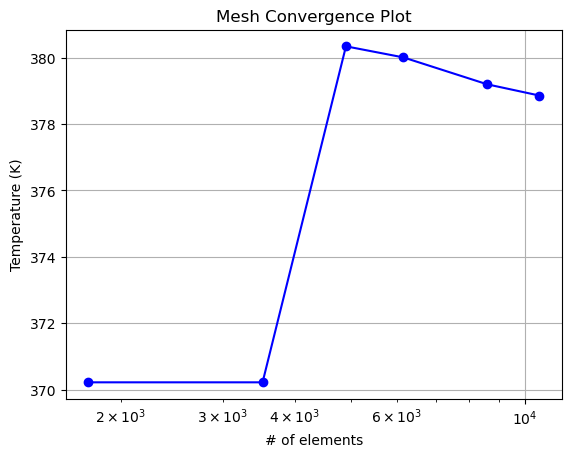

In [210]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(total_triangles_array, temp_array, marker='o', color='blue', linestyle='-', markersize=6)  # Set color, marker, and line style
plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Temperature (K)")  # Y-axis label
plt.title("Mesh Convergence Plot")  # Title

plt.show()

Text(0.5, 1.0, 'Relative Error plot')

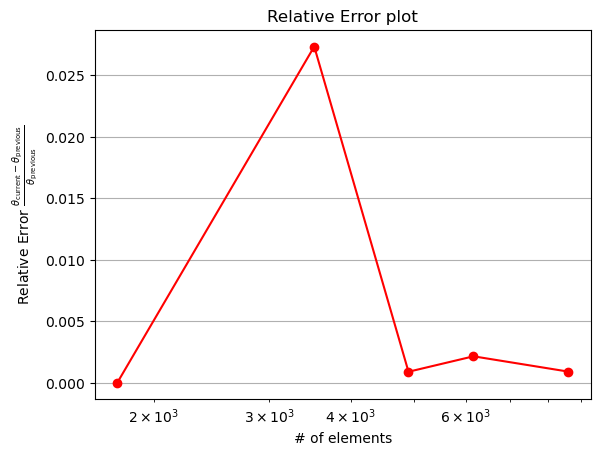

In [221]:
relative_error_array = []
for i in range(len(temp_array) - 1):
    relative_error_array.append(np.abs((temp_array[i+1] - temp_array[i])/temp_array[i]))
    
plt.plot(total_triangles_array[:len(relative_error_array)], relative_error_array, marker='o', color='red', linestyle='-', markersize=6)  # Set color, marker, and line style
plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel(r"Relative Error $\frac{\theta_{\text{current}} - \theta_{\text{previous}}}{\theta_{\text{previous}}}$")
plt.title("Relative Error plot")  # Title

In [143]:
gmsh.initialize()

# gmsh.open('IITM_Map_final')
gmsh.open('IITM_Map_sf17.5')

# Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

# Total number of nodes is the length of nodeTags
total_nodes = len(nodeTags)
coordinates = coordinates.reshape((-1, 3))

sorted_indices = np.argsort(nodeTags)
sorted_coordinates = coordinates[sorted_indices]


# coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
dim = 2 #for triangles
tag = -1 #get all
ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
node_tags = node_tags.reshape((-1,3))

triangle = []
for tag, nodes in zip(ele_tags, node_tags):
    x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
    x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
    x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
    triangle.append([x1,y1,x2,y2,x3,y3])
    
triangle = np.array(triangle)



# Retrieve boundary entities (1D entities in 2D mesh)
boundary_dim = 1  # For 2D meshes, boundary lines are 1D entities
boundary_tags = gmsh.model.getEntities(boundary_dim)

# Initialize arrays to store line coordinates and node numbers
boundary_lines = []
boundary_nodes = []
boundary_nodes_set = set()
# Loop through boundary entities
for dim, tag in boundary_tags:
    element_types, element_tags, node_tags_boundary = gmsh.model.mesh.getElements(dim, tag)
    node_tags_boundary = node_tags_boundary[0].reshape((-1, 2))  # Each 1D element is a line with 2 nodes

    # Loop through each line element (defined by 2 nodes)
    for nodes in node_tags_boundary:
        n1, n2 = nodes  # Convert to 0-based indexing
        x1, y1 = coordinates[int(n1), :2]  # Get coordinates for node 1
        x2, y2 = coordinates[int(n2), :2]  # Get coordinates for node 2
        boundary_lines.append([x1, y1, x2, y2])
        boundary_nodes.append([n1 + 1, n2 + 1])  # Store original 1-based node numbers
        boundary_nodes_set.add(n1)
        boundary_nodes_set.add(n2)

# Convert lists to numpy arrays
boundary_lines = np.array(boundary_lines)  # Shape: (no. of lines, 4) -> [x1, y1, x2, y2]
boundary_nodes = np.array(boundary_nodes, dtype=int)  # Shape: (no. of lines, 2) -> [node1, node2]
boundary_nodes_set = np.array(list(boundary_nodes_set), dtype=int)


gmsh.finalize()

In [144]:
C_static = solution_array[4]

In [145]:
C_static

array([[309.        ],
       [309.        ],
       [309.        ],
       ...,
       [310.78816617],
       [309.02540224],
       [414.06892591]])

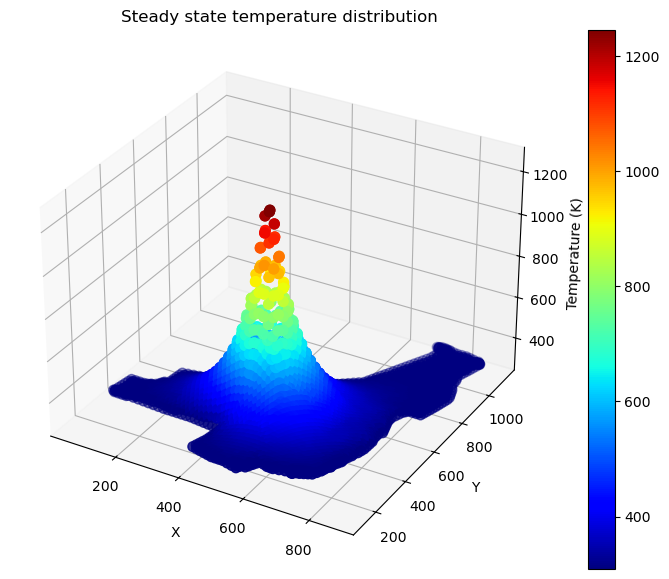

In [224]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = C_static[:, 0]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Steady state temperature distribution')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Temperature (K)')

# Invert the y-axis if needed
# ax.invert_yaxis()

# Show the plot
plt.show()

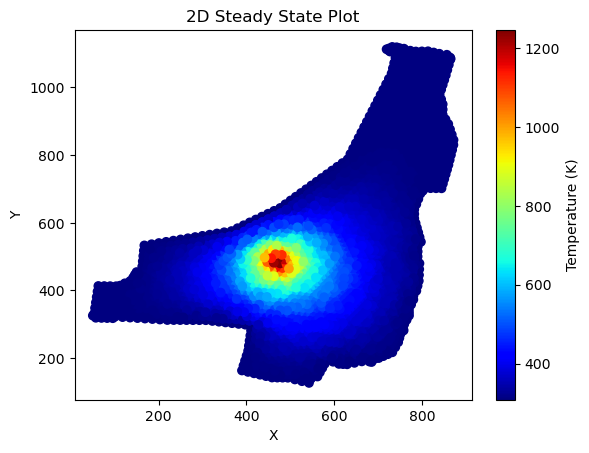

In [231]:
# Create a scatter plot
scatter = plt.scatter(x, y, c=temperature, cmap='jet')  # 'c' assigns color based on temperature

# Add a color bar to represent the temperature scale
plt.colorbar(scatter, label='Temperature (K)')  # Optional label for the color bar

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Steady State Plot')
# Show the plot
plt.show()

In [191]:
# residential = np.array([540,650])
# academic= np.array([300, 477.4])
# trial = np.array([600, 500])
# hostel = np.array([500,300])

In [249]:
residential = np.array([500,570])
academic= np.array([400, 477.4])
trial = np.array([600, 500])
hostel = np.array([500,430])

In [250]:
xy_coordinates = sorted_coordinates[:, :2]
residential_index = np.argmin(np.sum((xy_coordinates - residential)**2, axis=1))
academic_index = np.argmin(np.sum((xy_coordinates - academic)**2, axis=1))
hostel_index = np.argmin(np.sum((xy_coordinates - hostel)**2, axis=1))
trial_index = np.argmin(np.sum((xy_coordinates - trial)**2, axis=1))

In [251]:
sorted_coordinates[trial_index]

array([602.03798735, 500.72340134,   0.        ])

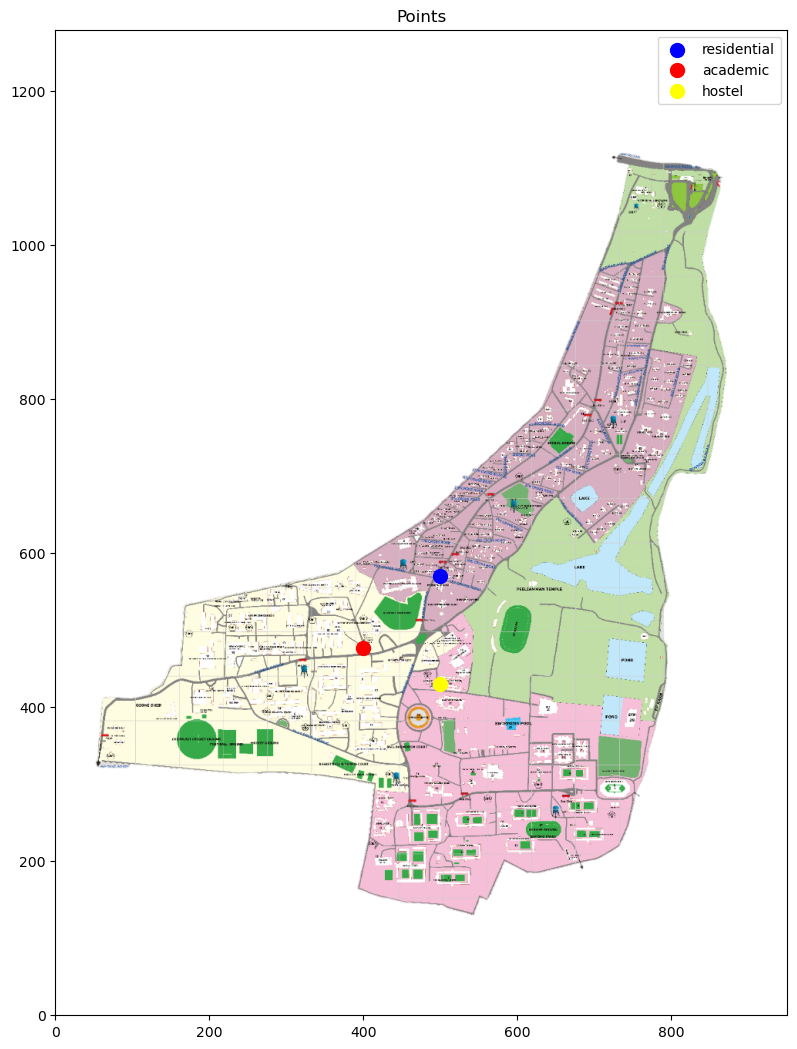

In [252]:
img = mpimg.imread('IITM_map_without_background.png')
img_height, img_width = img.shape[:2]  # Get image dimensions

# plt.imshow(image_rgb)
plt.figure(figsize=(img_width/100, img_height/100))  # Adjust figure size to match image size in inches

# Plot the image at its original size
plt.imshow(img, extent=[0, img_width, 0, img_height])
# # Plot the map, region boundary, and point
# plt.imshow(img)


# Plot the point you want to check
plt.scatter(residential[0], residential[1], c='blue', marker = 'o', label='residential', s=100)  # Larger point for the query location
plt.scatter(academic[0], academic[1], c='red', marker = 'o', label='academic', s=100)  # Larger point for the query location
plt.scatter(hostel[0], hostel[1], c='yellow', marker = 'o', label='hostel', s=100)  # Larger point for the query location
# plt.scatter(trial[0], trial[1], c='yellow', marker = 'o', label='trial', s=100)  # Larger point for the query location


plt.title(f"Points")
plt.legend()
plt.show()

TIME CONVERGENCE IMPLICIT

In [151]:
n = total_nodes
del_t_implicit = [0.01, 0.05, 0.1, 0.5, 1]
C_old = np.full((n, 1), 309)
time = 2
BC = ["dirichlet", "implicit"]
time_converged_array_implicit = []

In [152]:
point_time = np.array([700,500])
point_time_index = np.argmin(np.sum((xy_coordinates - point_time)**2, axis=1))

In [153]:
A_x, A_y = construct_bilinear(total_nodes, node_tags, triangle)
f = construct_forcing(total_nodes, node_tags, triangle)

In [154]:
for i in range(len(del_t_implicit)):
    count = 0
    M = construct_mass(total_nodes, node_tags, triangle, del_t_implicit[i])
    while count*del_t_implicit[i] <= time:
        count+=1
        C_new = transient_solution(BC, total_nodes, boundary_nodes_set, A_x, A_y, f, M, C_old)
        point_time_temp = C_new[point_time_index]
        C_old = C_new   
    time_converged_array_implicit.append(point_time_temp)

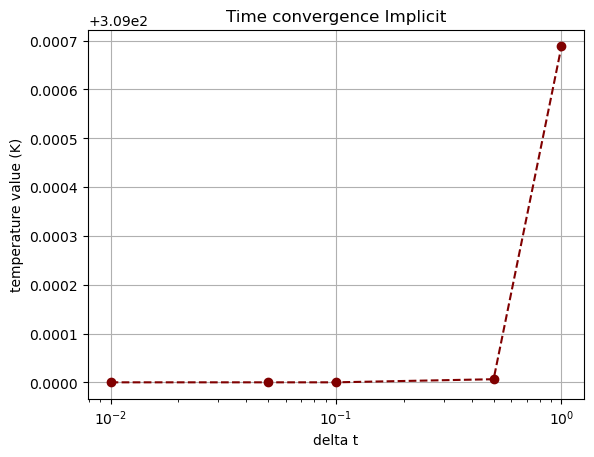

In [244]:
plt.plot(del_t_implicit, time_converged_array_implicit,  marker='o', color='maroon', linestyle='--', markersize=6 )
plt.xlabel('delta t')
plt.ylabel('temperature value (K)')
plt.title('Time convergence Implicit')

plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)

TIME CONVERGENCE EXPLICIT

In [156]:
n = total_nodes
del_t_explicit = [1e-3, 1e-2, 1e-1]
C_old = np.full((n, 1), 309)
time = 5e-1
BC = ["dirichlet", "explicit"]
time_converged_array_explicit = []

In [157]:
point_time = np.array([700,500])
point_time_index = np.argmin(np.sum((xy_coordinates - point_time)**2, axis=1))

In [158]:
A_x, A_y = construct_bilinear(total_nodes, node_tags, triangle)
f = construct_forcing(total_nodes, node_tags, triangle)

In [159]:
for i in range(len(del_t_explicit)):
    count = 0
    M = construct_mass(total_nodes, node_tags, triangle, del_t_explicit[i])
    while count*del_t_explicit[i] <= time:
        count+=1
        C_new = transient_solution(BC, total_nodes, boundary_nodes_set, A_x, A_y, f, M, C_old)
        point_time_temp = C_new[point_time_index]
        C_old = C_new   
    time_converged_array_explicit.append(point_time_temp)

(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)
(235,)

In [160]:
time_converged_array_explicit

[array([309.]), array([309.]), array([309.])]

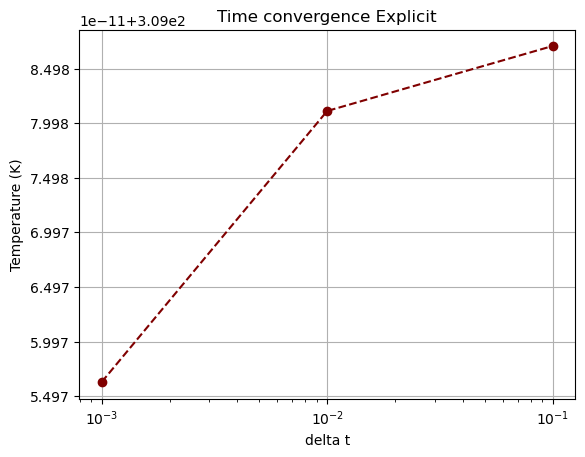

In [245]:
plt.plot(del_t_explicit, time_converged_array_explicit,  marker='o', color='maroon', linestyle='--', markersize=6)
plt.xlabel('delta t')
plt.ylabel('Temperature (K)')
plt.title('Time convergence Explicit')
plt.xscale('log')
plt.grid(True)

TRANSIENT PROBLEM

DIRICHLET and IMPLICIT SCHEME

In [260]:
n = total_nodes
del_t = 1
C_old = np.full((n, 1), 309)
steps = 500
BC = ["dirichlet", "implicit"]

In [254]:
A_x, A_y = construct_bilinear(total_nodes, node_tags, triangle)
f = construct_forcing(total_nodes, node_tags, triangle)

In [255]:
M = construct_mass(total_nodes, node_tags, triangle, del_t)

In [261]:
time_dict = {}

In [262]:
count = 0
while len(time_dict) < 3:
    count+=1
    C_new = transient_solution(BC, total_nodes, boundary_nodes_set, A_x, A_y, f, M, C_old)
    residential_temp = C_new[residential_index]
    academic_temp = C_new[academic_index]
    hostel_temp = C_new[hostel_index]
    trial_temp = C_new[trial_index]
    if residential_temp >= 319:
        if 'residential' not in time_dict:
            time_dict['residential'] = del_t*(count)
        
    if academic_temp >= 319:
        if 'academic' not in time_dict:
            time_dict['academic'] = del_t*(count)
    if hostel_temp >= 319:
        if 'hostel' not in time_dict:
            time_dict['hostel'] = del_t*(count)
            
    # if trial_temp >= 319:
    #     if 'trial' not in time_dict:
    #         time_dict['trial'] = del_t*(count)
    
    

    print(f"Residential : {residential_temp}    Academic : {academic_temp}    Hostel : {hostel_temp}")
    C_old = C_new    

Residential : [309.00000718]    Academic : [309.00009138]    Hostel : [309.00026681]
Residential : [309.00000118]    Academic : [309.00049666]    Hostel : [309.00053546]
Residential : [308.99998557]    Academic : [309.00104435]    Hostel : [309.00079952]
Residential : [308.9999687]    Academic : [309.0016064]    Hostel : [309.00105532]
Residential : [308.99995955]    Academic : [309.00211165]    Hostel : [309.00131347]
Residential : [308.99996519]    Academic : [309.00254992]    Hostel : [309.00160627]
Residential : [308.99998936]    Academic : [309.0029701]    Hostel : [309.00199161]
Residential : [309.000032]    Academic : [309.00347486]    Hostel : [309.00255427]
Residential : [309.00008936]    Academic : [309.00421332]    Hostel : [309.00340511]
Residential : [309.00015459]    Academic : [309.00537304]    Hostel : [309.00467905]
Residential : [309.00021857]    Academic : [309.00717201]    Hostel : [309.00653201]
Residential : [309.00027081]    Academic : [309.00985091]    Hostel : 

In [263]:
time_dict

{'academic': 84, 'hostel': 89, 'residential': 162}

In [266]:
C_new_d_i = C_new

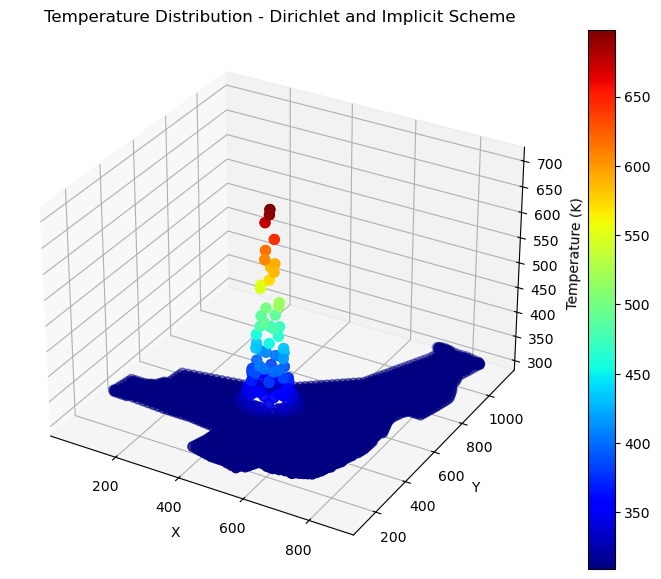

In [267]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = C_new_d_i[:, 0]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Temperature Distribution - Dirichlet and Implicit Scheme')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Temperature (K)')

# Invert the y-axis if needed
# ax.invert_yaxis()

# Show the plot
plt.show()

NEUMAN and IMPLICIT SCHEME

In [273]:
n = total_nodes
del_t = 1
C_old = np.full((n, 1), 309)
steps = 500
BC = ["neuman", "implicit"]

In [274]:
A_x, A_y = construct_bilinear(total_nodes, node_tags, triangle)
f = construct_forcing(total_nodes, node_tags, triangle)

In [275]:
M = construct_mass(total_nodes, node_tags, triangle, del_t)

In [276]:
time_dict_n_i = {}

In [277]:
count = 0
while len(time_dict_n_i) < 3:
    count+=1
    C_new_n_i = transient_solution(BC, total_nodes, boundary_nodes_set, A_x, A_y, f, M, C_old)
    residential_temp = C_new_n_i[residential_index]
    academic_temp = C_new_n_i[academic_index]
    hostel_temp = C_new_n_i[hostel_index]
    trial_temp = C_new_n_i[trial_index]
    if residential_temp >= 319:
        if 'residential' not in time_dict_n_i:
            time_dict_n_i['residential'] = del_t*(count)
        
    if academic_temp >= 319:
        if 'academic' not in time_dict_n_i:
            time_dict_n_i['academic'] = del_t*(count)
    if hostel_temp >= 319:
        if 'hostel' not in time_dict_n_i:
            time_dict_n_i['hostel'] = del_t*(count)
            
    # if trial_temp >= 319:
    #     if 'trial' not in time_dict:
    #         time_dict['trial'] = del_t*(count)
    
    

    print(f"Residential : {residential_temp}    Academic : {academic_temp}    Hostel : {hostel_temp}")
    C_old = C_new_n_i    

Residential : [309.00000718]    Academic : [309.00009138]    Hostel : [309.00026681]
Residential : [309.00000118]    Academic : [309.00049666]    Hostel : [309.00053546]
Residential : [308.99998557]    Academic : [309.00104435]    Hostel : [309.00079952]
Residential : [308.9999687]    Academic : [309.0016064]    Hostel : [309.00105532]
Residential : [308.99995955]    Academic : [309.00211165]    Hostel : [309.00131347]
Residential : [308.99996519]    Academic : [309.00254992]    Hostel : [309.00160627]
Residential : [308.99998936]    Academic : [309.0029701]    Hostel : [309.00199161]
Residential : [309.000032]    Academic : [309.00347486]    Hostel : [309.00255427]
Residential : [309.00008936]    Academic : [309.00421332]    Hostel : [309.00340511]
Residential : [309.00015459]    Academic : [309.00537304]    Hostel : [309.00467905]
Residential : [309.00021857]    Academic : [309.00717201]    Hostel : [309.00653201]
Residential : [309.00027081]    Academic : [309.00985091]    Hostel : 

In [278]:
time_dict_n_i

{'academic': 84, 'hostel': 89, 'residential': 162}

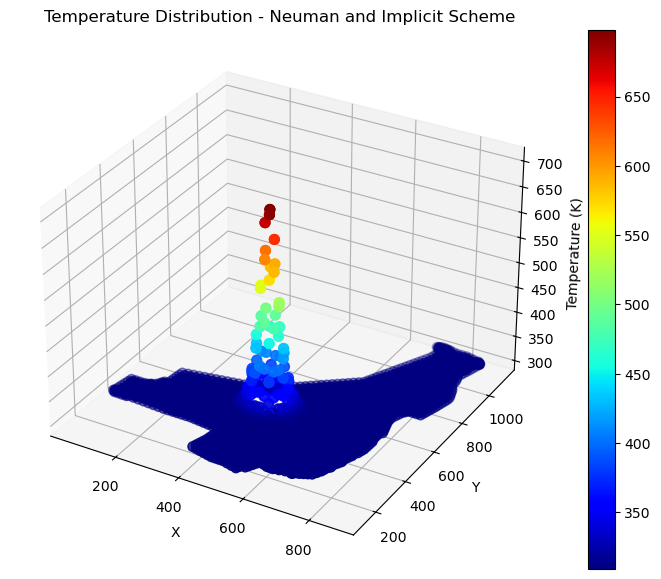

In [279]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = C_new_n_i[:, 0]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Temperature Distribution - Neuman and Implicit Scheme')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Temperature (K)')

# Invert the y-axis if needed
# ax.invert_yaxis()

# Show the plot
plt.show()

DIRICHLET and EXPLICIT SCHEME

In [285]:
n = total_nodes
del_t = 1e-1
C_old = np.full((n, 1), 309)
steps = 500
BC = ["dirichlet", "explicit"]

In [286]:
M = construct_mass(total_nodes, node_tags, triangle, del_t)

In [287]:
time_dict_d_e = {}

In [288]:
count = 0
while len(time_dict_d_e) < 3:
    count+=1
    C_new_d_e = transient_solution(BC, total_nodes, boundary_nodes_set, A_x, A_y, f, M, C_old)
    residential_temp = C_new_d_e[residential_index]
    academic_temp = C_new_d_e[academic_index]
    hostel_temp = C_new_d_e[hostel_index]
    trial_temp = C_new_d_e[trial_index]
    if residential_temp >= 319:
        if 'residential' not in time_dict_d_e:
            time_dict_d_e['residential'] = del_t*(count)
        
    if academic_temp >= 319:
        if 'academic' not in time_dict_d_e:
            time_dict_d_e['academic'] = del_t*(count)
    if hostel_temp >= 319:
        if 'hostel' not in time_dict_d_e:
            time_dict_d_e['hostel'] = del_t*(count)
            
    # if trial_temp >= 319:
    #     if 'trial' not in time_dict:
    #         time_dict['trial'] = del_t*(count)
    
    

    print(f"Residential : {residential_temp}    Academic : {academic_temp}    Hostel : {hostel_temp}")
    C_old = C_new_d_e    

Residential : [309.00000134]    Academic : [308.99995903]    Hostel : [309.00002719]
Residential : [309.00000288]    Academic : [308.99992461]    Hostel : [309.00005393]
Residential : [309.00000455]    Academic : [308.9998967]    Hostel : [309.0000803]
Residential : [309.0000063]    Academic : [308.99987523]    Hostel : [309.0001064]
Residential : [309.0000081]    Academic : [308.99986013]    Hostel : [309.00013231]
Residential : [309.0000099]    Academic : [308.99985127]    Hostel : [309.00015811]
Residential : [309.00001166]    Academic : [308.99984854]    Hostel : [309.00018386]
Residential : [309.00001334]    Academic : [308.99985179]    Hostel : [309.00020962]
Residential : [309.00001493]    Academic : [308.99986088]    Hostel : [309.00023545]
Residential : [309.00001638]    Academic : [308.99987562]    Hostel : [309.00026139]
Residential : [309.00001768]    Academic : [308.99989583]    Hostel : [309.00028748]
Residential : [309.00001879]    Academic : [308.99992133]    Hostel : [

In [289]:
time_dict_d_e

{'academic': 83.9, 'hostel': 88.9, 'residential': 161.5}

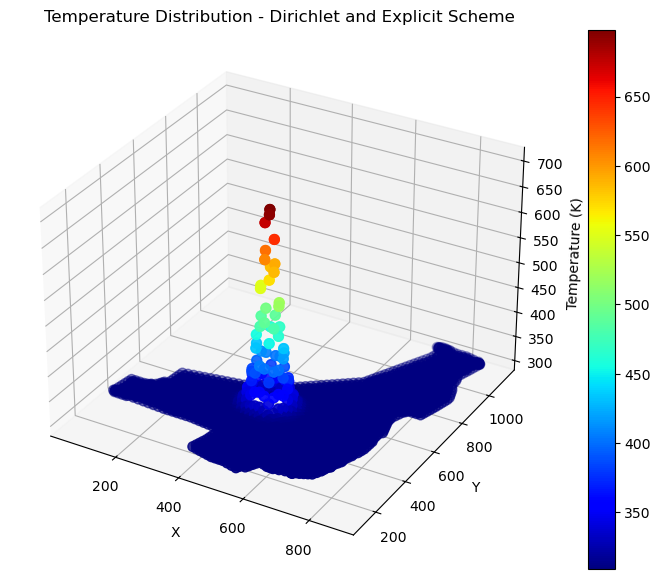

In [290]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = C_new_d_e[:, 0]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Temperature Distribution - Dirichlet and Explicit Scheme')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Temperature (K)')

# Invert the y-axis if needed
# ax.invert_yaxis()

# Show the plot
plt.show()

NEUMAN and EXPLICIT SCHEME

In [291]:
n = total_nodes
del_t = 1e-1
C_old = np.full((n, 1), 309)
steps = 500
BC = ["neuman", "explicit"]

In [292]:
time_dict_n_e = {}

In [293]:
count = 0
while len(time_dict_n_e) < 3:
    count+=1
    C_new_n_e = transient_solution(BC, total_nodes, boundary_nodes_set, A_x, A_y, f, M, C_old)
    residential_temp = C_new_n_e[residential_index]
    academic_temp = C_new_n_e[academic_index]
    hostel_temp = C_new_n_e[hostel_index]
    trial_temp = C_new_n_e[trial_index]
    if residential_temp >= 319:
        if 'residential' not in time_dict_n_e:
            time_dict_n_e['residential'] = del_t*(count)
        
    if academic_temp >= 319:
        if 'academic' not in time_dict_n_e:
            time_dict_n_e['academic'] = del_t*(count)
    if hostel_temp >= 319:
        if 'hostel' not in time_dict_n_e:
            time_dict_n_e['hostel'] = del_t*(count)
            
    # if trial_temp >= 319:
    #     if 'trial' not in time_dict:
    #         time_dict['trial'] = del_t*(count)
    
    

    print(f"Residential : {residential_temp}    Academic : {academic_temp}    Hostel : {hostel_temp}")
    C_old = C_new_n_e    

Residential : [309.00000134]    Academic : [308.99995903]    Hostel : [309.00002719]
Residential : [309.00000288]    Academic : [308.99992461]    Hostel : [309.00005393]
Residential : [309.00000455]    Academic : [308.9998967]    Hostel : [309.0000803]
Residential : [309.0000063]    Academic : [308.99987523]    Hostel : [309.0001064]
Residential : [309.0000081]    Academic : [308.99986013]    Hostel : [309.00013231]
Residential : [309.0000099]    Academic : [308.99985127]    Hostel : [309.00015811]
Residential : [309.00001166]    Academic : [308.99984854]    Hostel : [309.00018386]
Residential : [309.00001334]    Academic : [308.99985179]    Hostel : [309.00020962]
Residential : [309.00001493]    Academic : [308.99986088]    Hostel : [309.00023545]
Residential : [309.00001638]    Academic : [308.99987562]    Hostel : [309.00026139]
Residential : [309.00001768]    Academic : [308.99989583]    Hostel : [309.00028748]
Residential : [309.00001879]    Academic : [308.99992133]    Hostel : [

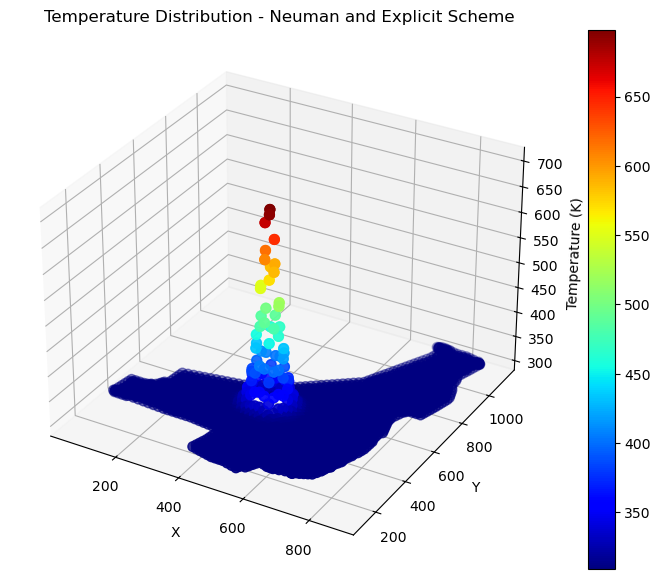

In [294]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = C_new_n_e[:, 0]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Temperature Distribution - Neuman and Explicit Scheme')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Temperature (K)')

# Invert the y-axis if needed
# ax.invert_yaxis()

# Show the plot
plt.show()

In [295]:
C_new_n_e

array([[309.        ],
       [309.        ],
       [309.        ],
       ...,
       [309.        ],
       [309.        ],
       [309.00000553]])

In [296]:
time_dict_n_e

{'academic': 83.9, 'hostel': 88.9, 'residential': 161.5}

Plotting all regions

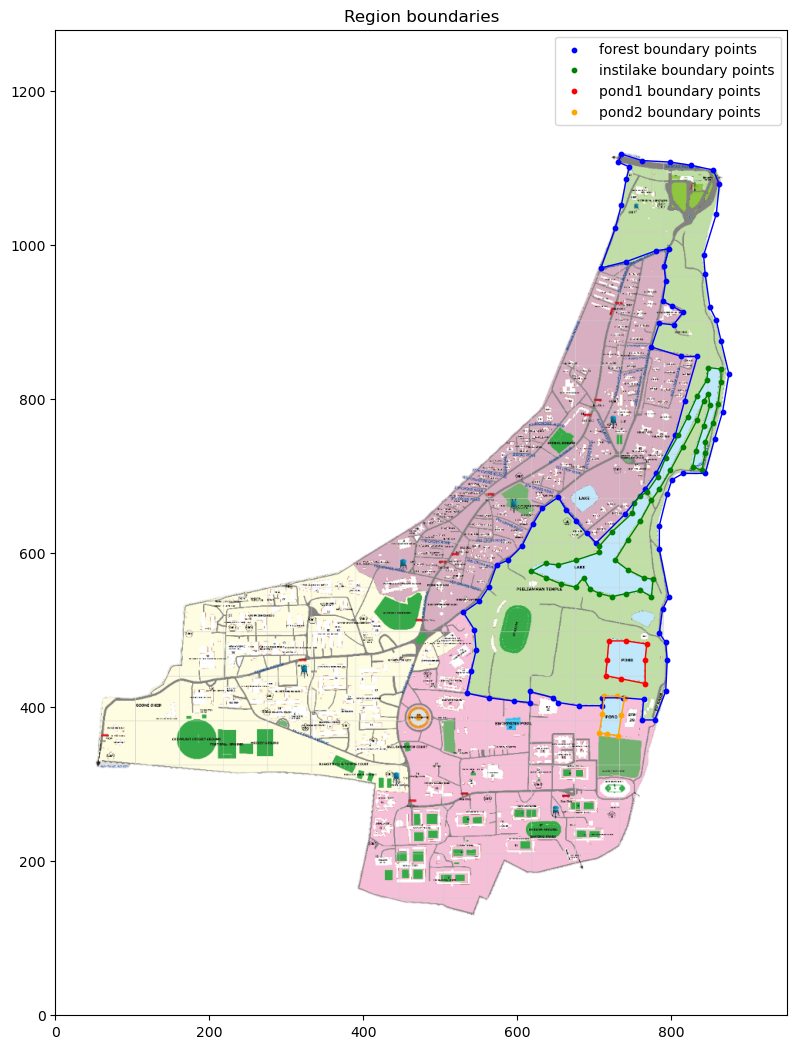

In [204]:
# Example usage
x, y = 472, 486.7  # Replace with your point coordinates
region_names = ['forest', 'instilake', 'pond1', 'pond2']  # Replace with the region you want to check
check_point_in_region_plot_all(region_names)